- https://www.kaggle.com/code/tuttifrutti/voronoi-diagram-in-python/notebook
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html#scipy.spatial.Voronoi
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.voronoi_plot_2d.html



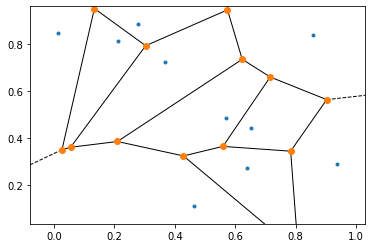

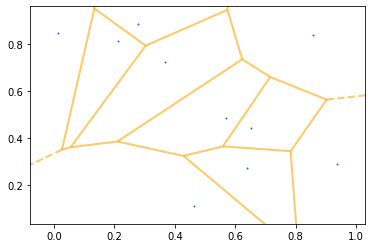

In [1]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
points = rng.random((10,2))
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
plt.show()


In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius * 10

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def get_dx_dy(angle, dist):
    cartesianAngleRadians = (450-angle)*math.pi/180.0
    dx = dist * math.cos(cartesianAngleRadians)
    dy = dist * math.sin(cartesianAngleRadians)
    return dx, dy

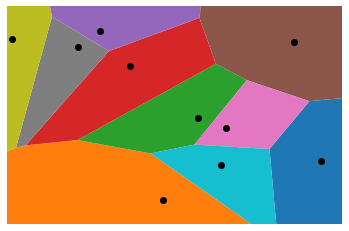

In [3]:
regions, vertices = voronoi_finite_polygons_2d(vor)
# get regions and vertices (nodes)
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon))
    
plt.plot(points[:,0], points[:,1], 'o',color='black',zorder=1)
plt.ylim(0 ,1)
plt.xlim(0, 1)
plt.axis('off')
plt.show()

- silly note to myself: for the purpose of ML (pixelized training) one simply needs to color the pixel with the color of the closest point - closest point issue - per definiton of Voronoi

In [4]:
print(points)

[[0.93672389 0.28830166]
 [0.46507441 0.11123986]
 [0.57057189 0.48570194]
 [0.36754206 0.72472052]
 [0.27712558 0.88466152]
 [0.85758763 0.83796603]
 [0.65307145 0.44207655]
 [0.21134012 0.8143027 ]
 [0.01318    0.84960128]
 [0.63752236 0.27077895]]


In [63]:
imd = np.ones(100*100*3)

In [64]:
np.shape(imd)

(30000,)

In [65]:
imd3=np.reshape(imd, (100,100,3))

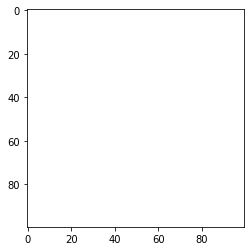

In [66]:
imgplot = plt.imshow(imd3)

In [67]:
cols = [(i+1)*1./(len(points)) for i in range(len(points))]
print(cols)
for i,p in enumerate(points):
    imd3[int(p[0]*100.)][int(p[1]*100.)][0]=cols[i]
    imd3[int(p[0]*100.)][int(p[1]*100.)][1]=0
    imd3[int(p[0]*100.)][int(p[1]*100.)][2]=0 

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


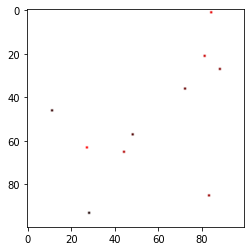

In [68]:
imgplot = plt.imshow(imd3)

In [84]:
import math
for ix in range(100):
    for iy in range(100):
        _dmin = 1.e4
        _dminxy = [-1,-1]
        _dmincol = -1
        for i,p in enumerate(points):
            _d = math.sqrt(math.pow((p[0]-ix/100.), 2) + math.pow((p[1]-iy/100.),2))
            if _d <= _dmin:
                _dmin = _d
                _dminxy[0] = ix
                _dminxy[1] = iy
                _dmincol = cols[i]
        if _dmin >= 2.0/100.:
            imd3[ix][iy][0]=_dmincol
            imd3[ix][iy][1]=_dmincol
            imd3[ix][iy][2]=_dmincol
        else:
            imd3[ix][iy][0]=_dmincol
            imd3[ix][iy][1]=0
            imd3[ix][iy][2]=0
            

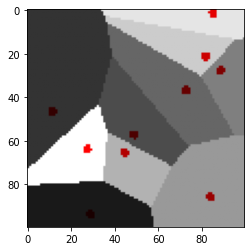

In [85]:
imgplot = plt.imshow(imd3)

In [86]:
import fastjet